In [1]:
# install.packages("readr")

In [2]:
library(readr)

In [3]:
 data_face <- read.table(file="./facerecognition.dat", header=TRUE)

 head(data_face)

,match,eyediff,nosecheekdiff,variabilityratio
,<int>,<dbl>,<dbl>,<dbl>
1,1,0.009682767,0.02791442,1.0862036
2,1,0.027613893,0.01782121,0.9898404
3,1,0.015366519,0.02583189,1.0109830
4,1,0.013371465,0.02404763,1.0127243
5,1,0.011427641,0.01780085,1.0443961
6,1,0.068604835,0.05038807,0.9508176


In [4]:
eyediff <- data_face$eyediff

x <- cbind(1, data_face$eyediff)
y <-  data_face$match

In [5]:
logistic_reg <- function(x, w) {
    z <- (x %*% w)
    p <- exp(z) / (1  + exp(z))

    return(p)
}

In [6]:
loglikelihood_func <- function(x, y, w) {
    p <- logistic_reg(x, w)
    total <- sum(y*log(p) + (1 - y)*log(1 - p))

    total
}

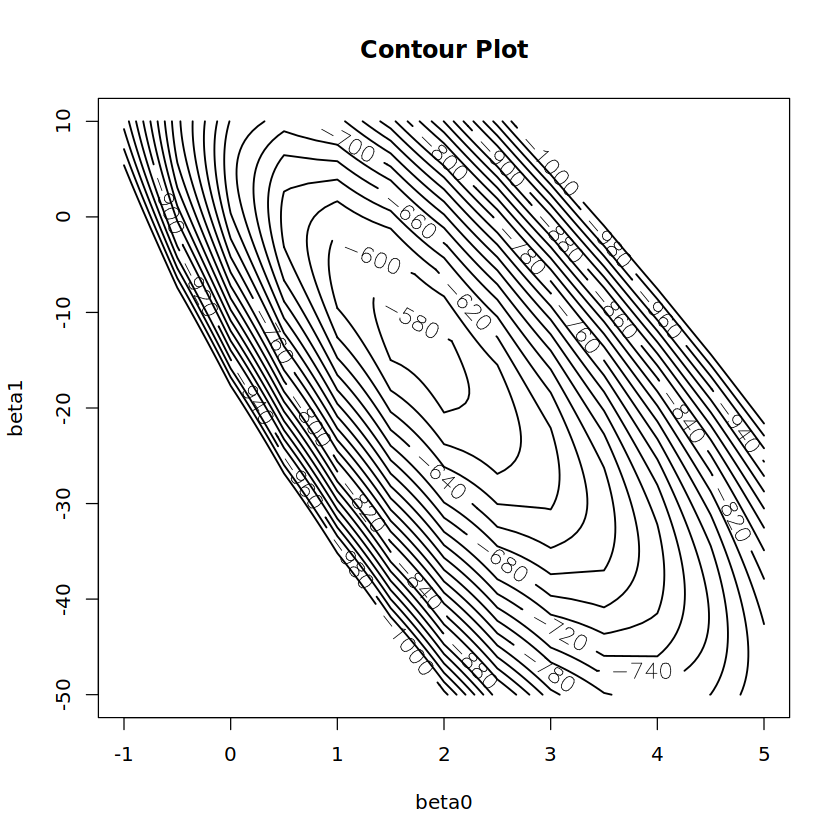

In [7]:
beta0_seq <- seq(-1, 5, by= 0.5)
beta1_seq <- seq(-50, 10, by= 0.5)


 z <- matrix(0, nrow = length(beta0_seq), ncol = length(beta1_seq))
 for(i in 1:length(beta0_seq)) {
     for(j in 1:length(beta1_seq)) {
        z[i, j] <- loglikelihood_func(x, y, c(beta0_seq[i], beta1_seq[j]))
     }
 }
# z <- outer(
#     beta0_seq, beta1_seq,
#     function(beta0, beta1) {
#         loglikelihood_func(x, y, c(beta0, beta1))
#     }
# )

contour(
    beta0_seq, beta1_seq, z,
    main = "Contour Plot",
    levels =  c(seq(-1000, -100, by = 20)),
    lwd = 1.5,
    xlab = "beta0",
    ylab = "beta1",
    labcex = 1.2
)

In [8]:
plot_optimal_point <- function(optimal_point, plot_name) {
   contour(
        beta0_seq, beta1_seq, z,
        levels =  c(seq(-1000, -100, by = 20)),
        lwd = 1.5,
        xlab = "alpha",
        ylab = "theta",
        labcex = 1.2
    )
    title(main=paste(strwrap(plot_name, width=60), collapse="\n"))
    points(
        x=optimal_point[1], y=optimal_point[2],
        pch = 16, type = "b", col="red", cex = 1.5)
}

In [9]:
grad_def_func <- function(x, y, params, step=1e-6) {
    val <- loglikelihood_func(x, y, params)
    grad1 <- (loglikelihood_func(x, y, c(params[1] + step,params[2])) - val) / step
    grad2 <- (loglikelihood_func(x, y, c(params[1], params[2] + step)) - val) / step

    c(grad1, grad2)
}

In [10]:
grad_func <- function(x, y, params) {
    p <- logistic_reg(x, params)
    
    t(x)%*%(y - p)
}

In [11]:
# gradient check

# params <- c(3, 3)

# val1 <- grad_def_func(x, y, params, step=1e-7)
# val2 <- grad_func(x, y, params)
# dist <- norm(val1 - val2, type="2")
# print(sprintf("Distance: %f", dist))

In [12]:
second_grad_func <- function(x, y, params) {
    p <- logistic_reg(x, params)
    w <- c(p*(p - 1))
    diag_w <- diag(w, length(w), length(w))

    t(x) %*% diag_w %*%x
}

### Naive Newton method

In [13]:
newton_updating <- function(x, y, params) {
    grad <- grad_func(x, y, params)
    hess <- second_grad_func(x, y, params)
    d <- -solve(hess, grad)
    
    params <- params + d
}

newton_optimizer <- function(x, y, max_iter, threshold, params) {
    for (i in 1:max_iter) {
        iter <- i
        old_params <- params
        params <- newton_updating(x, y, old_params)

        err <- norm(params - old_params, type="2")
        if (is.na(err)) {
             return(list(iters=iter, params=params))
        }
        
        if (err <= threshold) {
            return(list(iters=iter, params=params))
        }
    }

    return(list(iters=iter, params=params))
}

[1] "RMSE: 0.4251"
Interations: 5, initial points: (0.50, 1.00) optimal points: (1.7587, -13.4000)

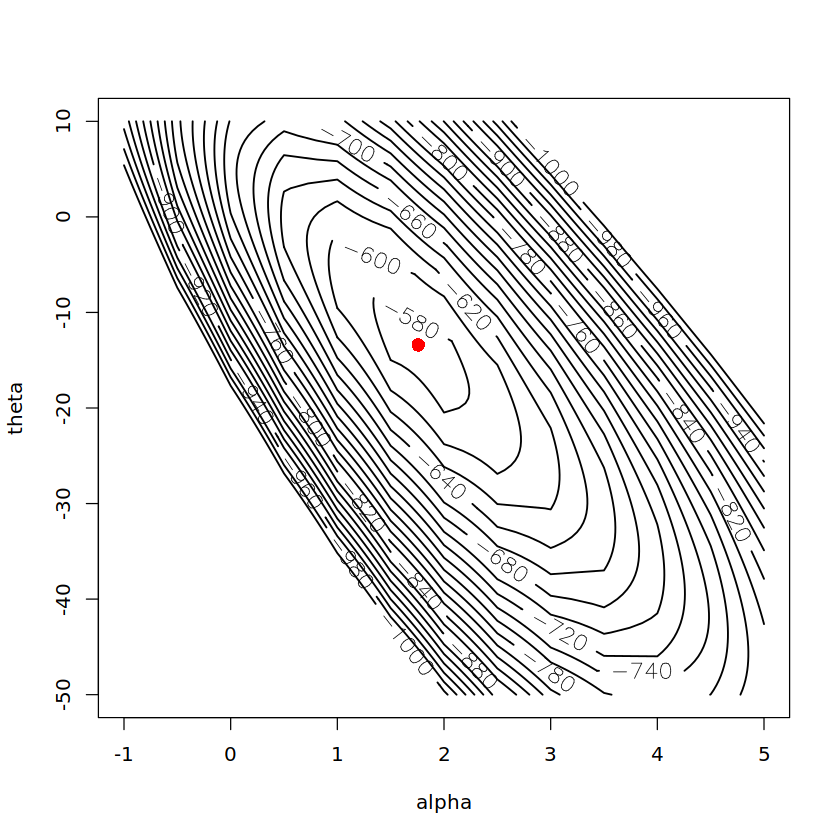

In [14]:
max_iter <- 70
threshold <- 1e-5

init_params <- c(0.5, 1)

result <- newton_optimizer(x, y, max_iter, threshold, init_params)
p <- logistic_reg(x, result$params)
# Calculate RMSE
rmse <- sqrt(mean((y - p)^2))
print(sprintf("RMSE: %.4f", rmse))
plot_name <- cat(sprintf("Interations: %d, initial points: (%.2f, %.2f)",
                     result$iters, init_params[1], init_params[2]),
                sprintf("optimal points: (%.4f, %.4f)",
                        result$params[1], result$params[2]))
plot_optimal_point(result$params, plot_name)

Interations: 4, initial points: (3.00, 4.00) optimal points: (NaN, NaN)

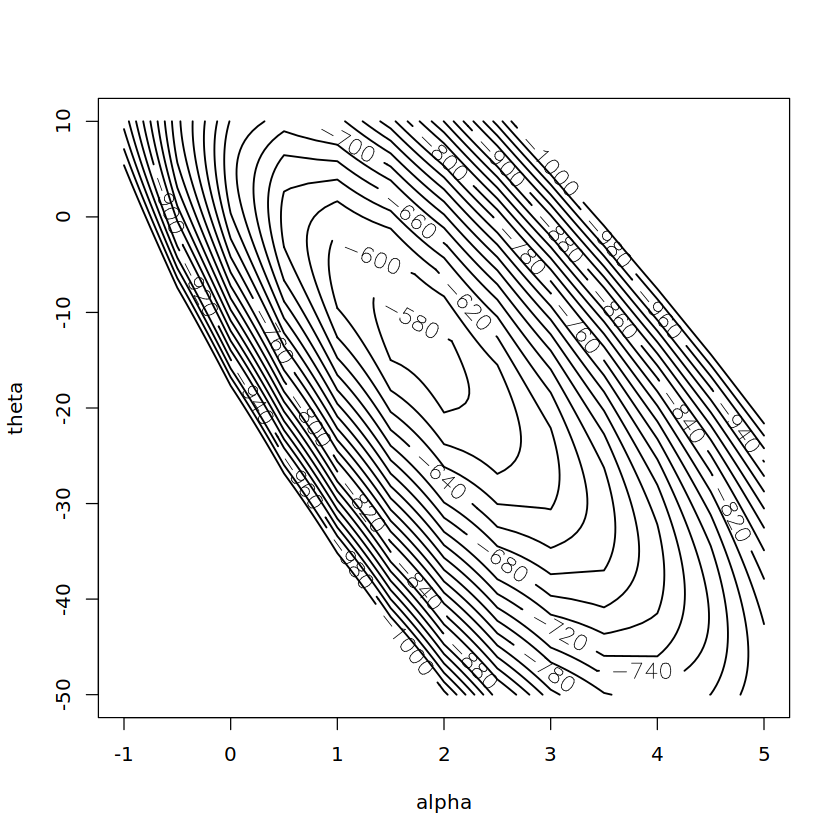

In [15]:
max_iter <- 50
threshold <- 1e-5

init_params <- c(3, 4)

result <- newton_optimizer(x, y, max_iter, threshold, init_params)
plot_name <- cat(sprintf("Interations: %d, initial points: (%.2f, %.2f)",
                     result$iters, init_params[1], init_params[2]),
                sprintf("optimal points: (%.4f, %.4f)",
                        result$params[1], result$params[2]))
plot_optimal_point(result$params, plot_name)

In [16]:
fisher_matrix <- function(x, y, params) {
    -second_grad_func(x, y, params)
}

In [17]:
is_greater <- function(params, old_params) {
    f <- loglikelihood_func(x, y, params)
    old_f <- loglikelihood_func(x, y, old_params)
    
    return(f < old_f)
}

newtonlike_updating <- function(params, M, grad, a) {
    d <- solve(M, grad)
    
    params <- params - a*d
}

hess_updating <- function(x, y, params, old_params, M, old_grad) {
    h <- params - old_params
    u <- grad_func(x, y, params) - old_grad
    h_trans <- t(h)
    m_h <- M %*% h
    num1 <- m_h %*% t(m_h)
    de1 <- as.numeric(h_trans %*% m_h)
    num2 <- u %*% t(u)
    de2 <- as.numeric(h_trans %*% u)

    M <- M - num1/de1 + num2/de2
}

### Steepest Ascent

In [18]:
steepest_ascent_optimizer <- function(x, y, max_iter, threshold, params) {
    for (i in 1:max_iter) {
        iter <- i
        a <- 1.
        old_params <- params
        grad <- grad_func(x, y, params)
        M <- -fisher_matrix(x, y, params)
        params <- newtonlike_updating(old_params, M, grad, a)

        count <- 0
        while(is_greater(params, old_params) && (count < 10)) {
            a <- a / 2.
            param <- newtonlike_updating(old_params, M, grad, a)
            count <- count + 1
        }
        if (norm(params - old_params, type="2") <= threshold) {
            return(list(iters=iter, params=params))
        }
        
        if (norm(params - old_params, type="2") <= threshold) {
            return(list(iters=iter, params=params))
        }
    }

    return(list(iters=iter, params=params))
}

[1] "RMSE: 0.4251"
Interations: 5, initial points: (0.50, 2.00) optimal points: (1.7587, -13.4000)

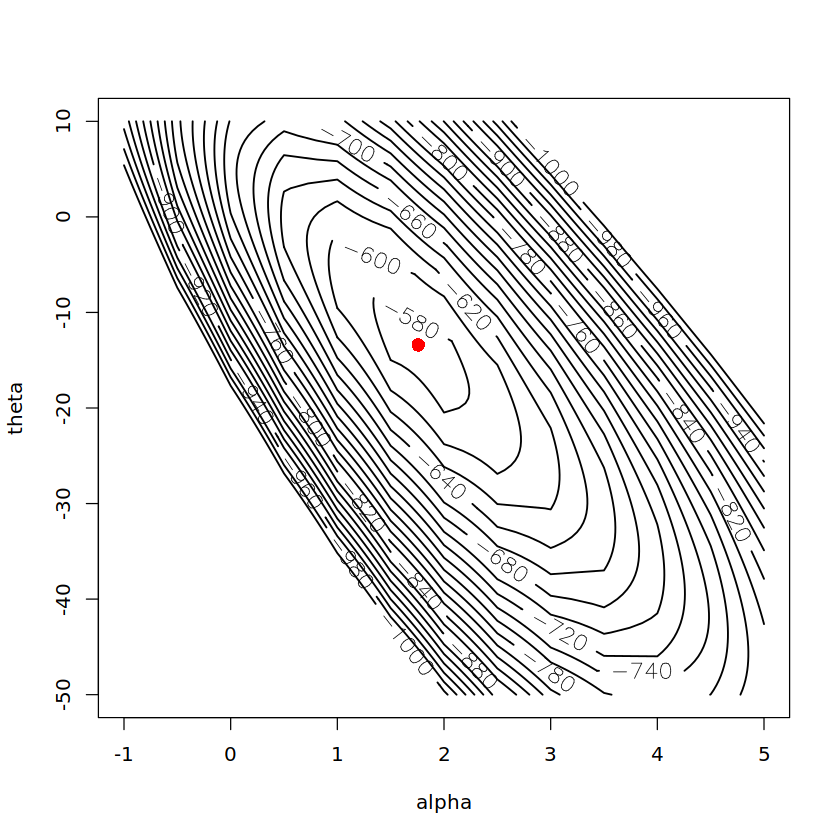

In [19]:
max_iter <- 50
threshold <- 1e-5

init_params <- c(0.5, 2)

result <- steepest_ascent_optimizer(x, y, max_iter, threshold, init_params)
p <- logistic_reg(x, result$params)
# Calculate RMSE
rmse <- sqrt(mean((y - p)^2))
print(sprintf("RMSE: %.4f", rmse))
plot_name <- cat(sprintf("Interations: %d, initial points: (%.2f, %.2f)",
                     result$iters, init_params[1], init_params[2]),
                sprintf("optimal points: (%.4f, %.4f)",
                        result$params[1], result$params[2]))
plot_optimal_point(result$params, plot_name)

### Quasi-Newton method

In [20]:
bfgs_optimizer <- function(x, y, max_iter, threshold, params) {
    for (i in 1:max_iter) {
        iter <- i
        a <- 1.
        old_params <- params
        grad <- grad_func(x, y, params)
        M <- -fisher_matrix(x, y, params)
        params <- newtonlike_updating(old_params, M, grad, a)

        count <- 0
        while(is_greater(params, old_params) && (count < 10)) {
            a <- a / 2.
            param <- newtonlike_updating(old_params, M, grad, a)
            count <- count + 1
        }
        if (norm(params - old_params, type="2") <= threshold) {
            return(list(iters=iter, params=params))
        }
        M <- hess_updating(x, y, params, old_params, M, grad)
    }

    return(list(iters=iter, params=params))
}

[1] "RMSE: 0.4251"
Interations: 5, initial points: (0.50, 2.00) optimal points: (1.7587, -13.4000)

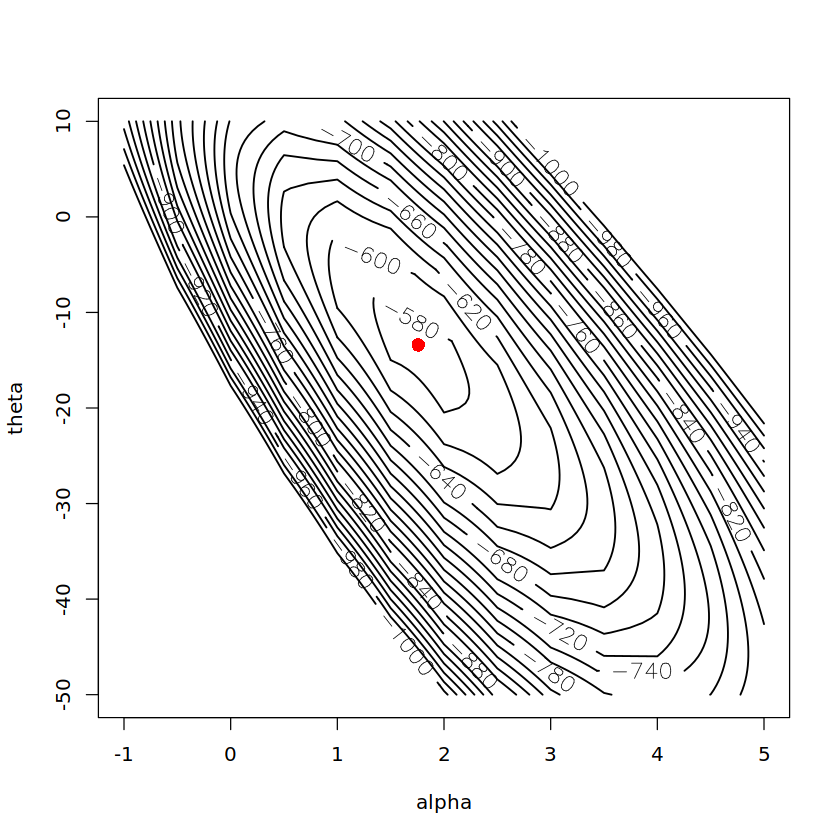

In [21]:
max_iter <- 50
threshold <- 1e-5

init_params <- c(0.5, 2)

result <- bfgs_optimizer(x, y, max_iter, threshold, init_params)
p <- logistic_reg(x, result$params)
# Calculate RMSE
rmse <- sqrt(mean((y - p)^2))
print(sprintf("RMSE: %.4f", rmse))
plot_name <- cat(sprintf("Interations: %d, initial points: (%.2f, %.2f)",
                     result$iters, init_params[1], init_params[2]),
                sprintf("optimal points: (%.4f, %.4f)",
                        result$params[1], result$params[2]))
plot_optimal_point(result$params, plot_name)

### Using `eyediff`, `nosecheekdiff`, `variabilityratio`

In [22]:
head(data_face[c("eyediff", "nosecheekdiff", "variabilityratio")])

,eyediff,nosecheekdiff,variabilityratio
,<dbl>,<dbl>,<dbl>
1,0.009682767,0.02791442,1.0862036
2,0.027613893,0.01782121,0.9898404
3,0.015366519,0.02583189,1.0109830
4,0.013371465,0.02404763,1.0127243
5,0.011427641,0.01780085,1.0443961
6,0.068604835,0.05038807,0.9508176


In [23]:
x <- as.matrix(cbind(1, data_face[c("eyediff", "nosecheekdiff", "variabilityratio")]))
y <-  data_face$match

In [24]:
max_iter <- 70
threshold <- 1e-5

init_params <- c(0.5, 1.5, 2, 1.)

result <- newton_optimizer(x, y, max_iter, threshold, init_params)
p <- logistic_reg(x, result$params)
# Calculate RMSE
rmse <- sqrt(mean((y - p)^2))
print(sprintf("RMSE: %.4f", rmse))

[1] "RMSE: 0.3948"


In [25]:
max_iter <- 70
threshold <- 1e-5

init_params <- c(0.5, 1.5, 2, 1.)

result <- steepest_ascent_optimizer(x, y, max_iter, threshold, init_params)
p <- logistic_reg(x, result$params)
# Calculate RMSE
rmse <- sqrt(mean((y - p)^2))
print(sprintf("RMSE: %.4f", rmse))

[1] "RMSE: 0.3948"


In [26]:
max_iter <- 70
threshold <- 1e-5

init_params <- c(0.5, 1.5, 2, 1.)

result <- bfgs_optimizer(x, y, max_iter, threshold, init_params)
p <- logistic_reg(x, result$params)
# Calculate RMSE
rmse <- sqrt(mean((y - p)^2))
print(sprintf("RMSE: %.4f", rmse))

[1] "RMSE: 0.3948"
